## The purpose here is to split the dataset into a train and test(65/35) and run Linear Regression models to calcuate the T/T/S.

In [14]:
from google.colab import files
uploaded = files.upload()

Saving clean.csv to clean.csv


In [15]:
# Probably shouldn't do this all at once, but better now than to stress later on
# down the line. I am importing the libraries that I will need.
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from sklearn import linear_model
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import pylab
import scipy.stats as stats
%matplotlib inline

In [16]:
# This section of code will create a helper function for plotting residual plots.

def plot_residual(ax1, ax2, ax3, y_pred, y_real, line_label, title):
    ax1.scatter(y_pred, 
                y_real, 
                color='blue',
                alpha=0.6,
                label=line_label)
    ax1.set_xlabel('Predicted Y') 
    ax1.set_ylabel('Real Y')
    ax1.legend(loc='best')
    ax1.set_title(title)

    ax2.scatter(y_pred,
                y_real - y_pred, 
                color='green',
                marker='x',
                alpha=0.6,
                label='Residual')
    ax2.set_xlabel('Predicted Y')
    ax2.set_ylabel('Residual')
    
    ax2.axhline(y=0, color='black', linewidth=2.0, alpha=0.7, label='y=0')

    ax2.legend(loc='best')
    ax2.set_title('Residual Plot')
    
    ax3.hist(y_real - y_pred, bins=30, color='green', alpha=0.7)
    ax3.set_title('Histogram of residual values')
    
    return ax1, ax2, ax3

In [17]:
# As stated previously, this section of code will create a model class that will
# output both the Mean Test and Mean Train scores.

class model:
      
    def __init__(self, model):
        self.model = model
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.y_pred_train = None
        self.y_pred_test = None
        self.train_score = None
        self.test_score = None
        self.train_score_log = None
        self.test_score_log = None
    
    def data_split(self, x, y, test_size):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, test_size=test_size)
    
    def score_reg(self):
        return self.train_score, self.test_score
    
    def score_log(self):
        self.train_score_log = metrics.r2_score(np.exp(self.y_train), np.exp(self.y_pred_train))
        self.test_score_log = metrics.r2_score(np.exp(self.y_test), np.exp(self.y_pred_test))
        return self.train_score_log, self.test_score_log
    
    def data_frame_convert(self):
        df_train = pd.DataFrame({'y_pred': self.y_pred_train, 'y_real': self.y_train})
        df_test = pd.DataFrame({'y_pred_test': self.y_pred_test, 'y_real_test': self.y_test})
        return self.train_score, self.test_score, df_train, df_test

    def data_frame_convert_log(self):
        df_train = pd.DataFrame({'y_pred': np.exp(self.y_pred_train), 'y_real': np.exp(self.y_train)})
        df_test = pd.DataFrame({'y_pred_test': np.exp(self.y_pred_test), 'y_real_test': np.exp(self.y_test)})
        return self.train_score_log, self.test_score_log, df_train, df_test
    
    def fit_model(self, x, y, test_size):
        self.data_split(x, y, test_size)
        self.model = self.model.fit(self.x_train, self.y_train)
        self.train_score = self.model.score(self.x_train, self.y_train)
        self.test_score = self.model.score(self.x_test, self.y_test)
        self.y_pred_train = self.model.predict(self.x_train)
        self.y_pred_test = self.model.predict(self.x_test)
    
def model_iterations(n, x, y, model_arg, log_bool=False):
    training_scores = [None]*n
    testing_scores = [None]*n

    for i in range(n):
        new_model = model(model_arg)
        new_model.fit_model(x, y, 0.3)
        training_scores[i], testing_scores[i] = new_model.score_reg() if not log_bool else new_model.score_log()

    print('Mean Train Score:', np.mean(training_scores))
    print('Mean Test Score:', np.mean(testing_scores))
    return new_model

In [18]:
df = pd.read_csv('clean.csv')
df.head()

,id,host_id,accommodates,bathrooms,bedrooms,beds,minimum_nights,availability_30,number_of_reviews,host_listing_count,10001,10002,10003,10004,10005,10006,10007,10009,10010,10011,10012,10013,10014,10016,10017,10018,10019,10021,10022,10023,10024,10025,10026,10027,10028,10029,10030,10031,10032,10033,...,14072,Apartment,Bed & Breakfast,Boat,Cabin,Camper/RV,Castle,Cave,Chalet,Dorm,Earth House,House,Hut,Lighthouse,Loft,Other,Tent,Treehouse,Villa,Entire home/apt,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed,20-29,30-39,40-49,50-59,60-69,70-79,80-84,85-89,90-94,95-100,No Reviews,price,price_log
0,1069266,5867023,-0.520266,-0.331542,-0.407402,-0.493039,0.173906,0.390393,2.716107,-0.355961,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,160.0,5.075174
1,2061725,4601412,-0.520266,-0.331542,-0.407402,0.381672,0.173906,-0.965897,1.295605,0.933455,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,58.0,4.060443
2,44974,198425,-0.520266,-0.331542,-0.407402,-0.493039,2.889531,-1.205242,0.822104,-0.355961,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,185.0,5.220356
3,4701675,22590025,-0.520266,-0.331542,-0.407402,0.381672,-0.601986,1.108429,-0.493176,-0.355961,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,195.0,5.273000
4,68914,343302,1.690892,-0.331542,1.266328,1.256383,-0.214040,-0.407424,0.295992,0.073844,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,165.0,5.105945


In [20]:
# split into x and y (note that we do not include id and host_id as predictors)
x = df.iloc[:, 2:-2]
y = df.iloc[:, -2]
y_log = df.iloc[:, -1]

## From this point forward, I will be running some LR(Linear Regression) model simulations. I will start with a Non-Trasformed Response.

In [22]:
Lin_Reg_Model = model_iterations(1, x, y, Lin_Reg(fit_intercept=True))

Mean Train Score: 0.333914040125313
Mean Test Score: -4.849563057502652e+16


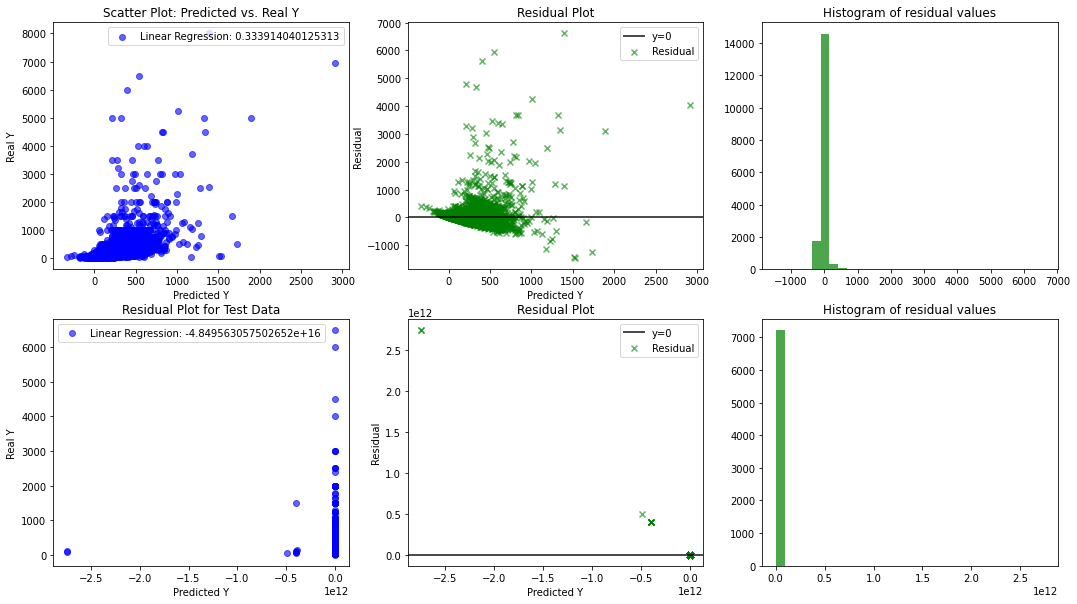

In [24]:

# plot the residuals of a linear regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

data_vals = Lin_Reg_Model.data_frame_convert()
plot_residual(axes[0][0], axes[0][1], axes[0][2], data_vals[2]['y_pred'], data_vals[2]['y_real'], 'Linear Regression: {}'.format(data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], data_vals[3]['y_pred_test'], data_vals[3]['y_real_test'], 'Linear Regression: {}'.format(data_vals[1]), 'Residual Plot for Test Data')
plt.show()

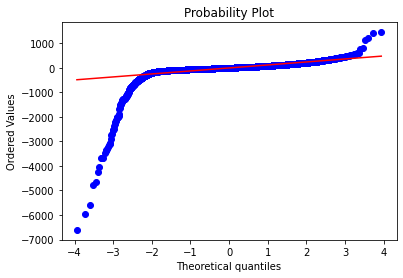

In [25]:
# qq plot for the train residuals
stats.probplot(data_vals[2]['y_pred'] - data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

## Since we have a visual grasp on the LR model without a LT-R we will now work with the same model but with a LT-R

In [27]:
Lin_Reg_Model_Log = model_iterations(1, x, y_log, Lin_Reg(fit_intercept=True))

Mean Train Score: 0.7009004918486544
Mean Test Score: -1209869085677.5166


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


ValueError: ignored

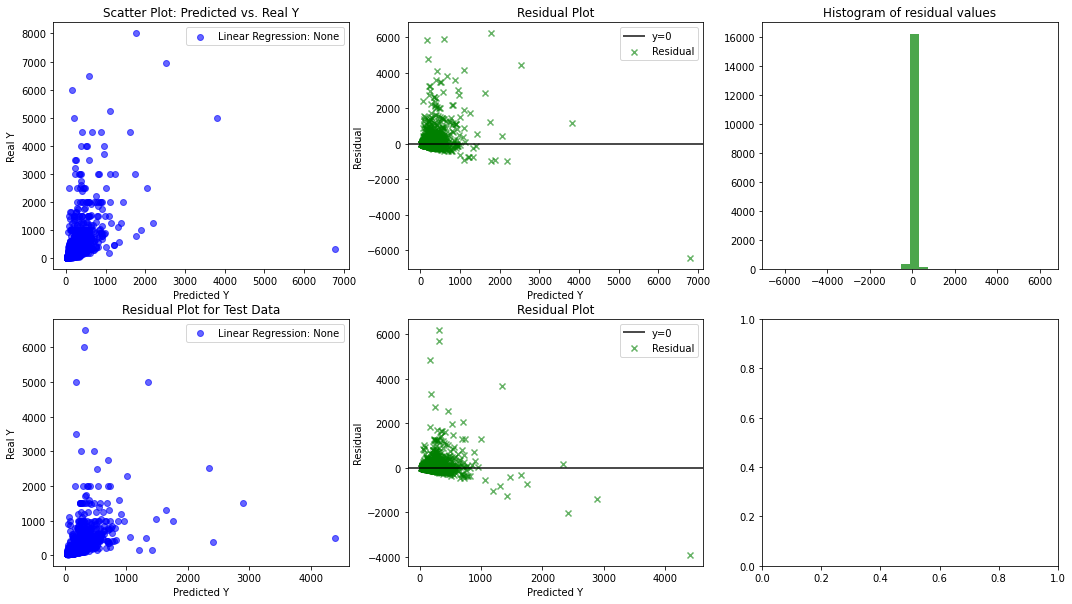

In [28]:
# plot the residuals of a linear regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

data_vals = Lin_Reg_Model_Log.data_frame_convert_log()
plot_residual(axes[0][0], axes[0][1], axes[0][2], data_vals[2]['y_pred'], data_vals[2]['y_real'], 'Linear Regression: {}'.format(data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], data_vals[3]['y_pred_test'], data_vals[3]['y_real_test'], 'Linear Regression: {}'.format(data_vals[1]), 'Residual Plot for Test Data')
plt.show()

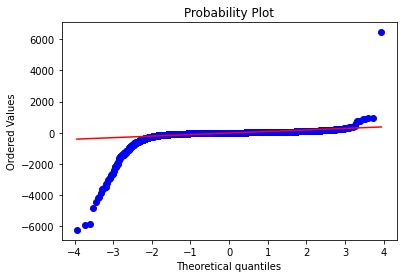

In [29]:
# qq plot for the train residuals
stats.probplot(data_vals[2]['y_pred'] - data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

## Linear Regression witn Untransformed Response

  * This specific model outputs a relatively low $R^2$ score on the train set and an extreme low $R^2$ score on the test set. Based on the plots, the LR model didn't perform as well as it does predicting. However; from the plots themselves we can see an outward cone pattern which indicates nonlinearity in the data. So when I went to plot the residuals in test, the majority were predicted to be 0; however, there were quite a few cases where the y-value was not 0.

## Linear Regression with Log-Transformed Response

  * With the LR model, visually speaking the response yields somewhat of a similiar $R^2$ value in the training set, although a much higher value for the test set. The training score still remained similar for both the transformed and non-transformed models. 
  * Now that we have a baseline for our model, I will fit several other models against it. 

### Ridge and Lasso Regression Models

  * Ridge Regression(RR) with Untransformed Response


In [30]:
reg_params = 10.**np.linspace(-10, 5, 10)
RidgeCV_model = model_iterations(5, x, y, RidgeCV(alphas=reg_params, fit_intercept=True, cv=5))

Mean Train Score: 0.326104930332723
Mean Test Score: 0.2916220034160137


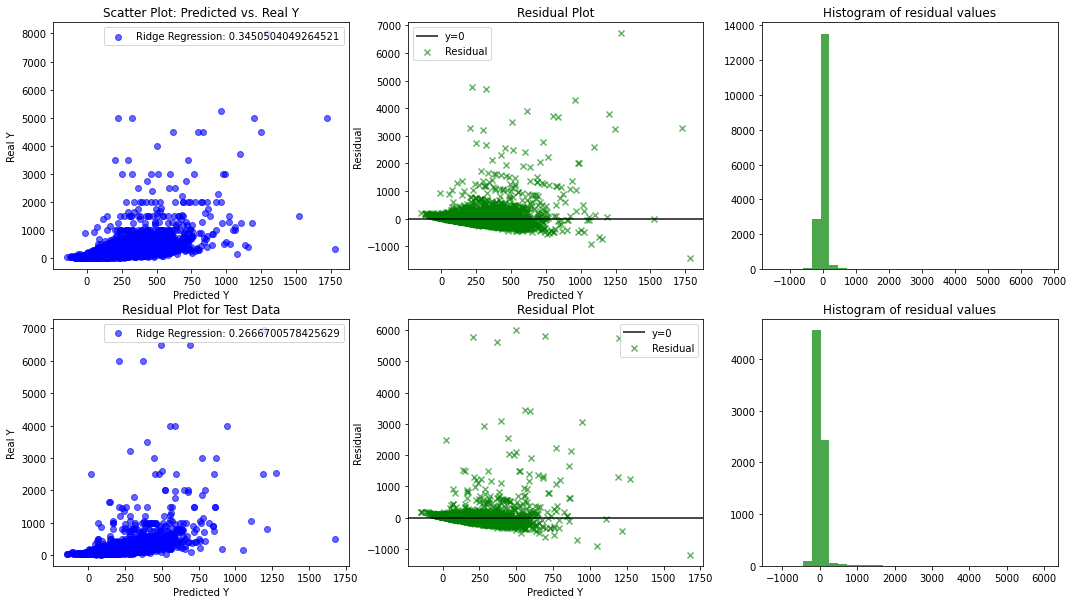

In [31]:
# plot the residuals of a ridge regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

ridge_data_vals = RidgeCV_model.data_frame_convert()
plot_residual(axes[0][0], axes[0][1], axes[0][2], ridge_data_vals[2]['y_pred'], ridge_data_vals[2]['y_real'], 'Ridge Regression: {}'.format(ridge_data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], ridge_data_vals[3]['y_pred_test'], ridge_data_vals[3]['y_real_test'], 'Ridge Regression: {}'.format(ridge_data_vals[1]), 'Residual Plot for Test Data')
plt.show()

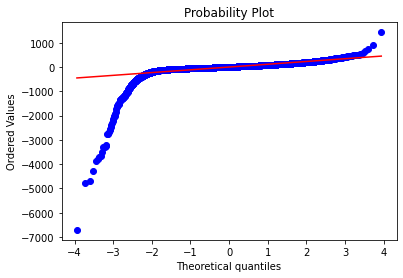

In [32]:
# qq plot for the train residuals
stats.probplot(ridge_data_vals[2]['y_pred'] - ridge_data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

### Ridge Regression(RR) with Log-Transformed Response

In [33]:
reg_params = 10.**np.linspace(-10, 5, 10)
RidgeCV_model = model_iterations(5, x, y_log, RidgeCV(alphas=reg_params, fit_intercept=True, cv=5), True)

Mean Train Score: 0.33181804219387045
Mean Test Score: 0.28880501431943345


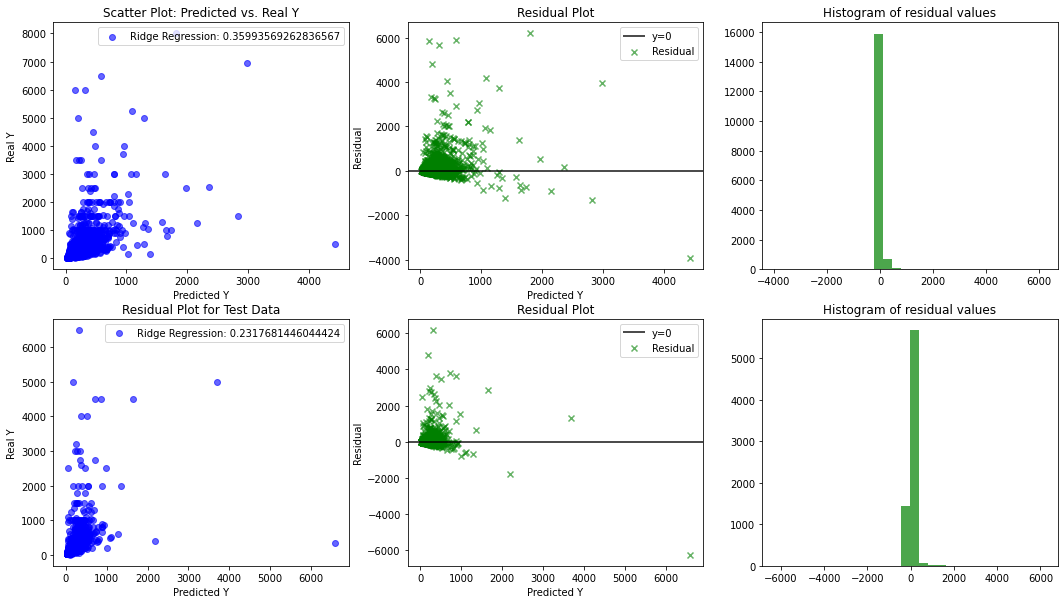

In [34]:
# plot the residuals of a ridge regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

ridge_data_vals = RidgeCV_model.data_frame_convert_log()
plot_residual(axes[0][0], axes[0][1], axes[0][2], ridge_data_vals[2]['y_pred'], ridge_data_vals[2]['y_real'], 'Ridge Regression: {}'.format(ridge_data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], ridge_data_vals[3]['y_pred_test'], ridge_data_vals[3]['y_real_test'], 'Ridge Regression: {}'.format(ridge_data_vals[1]), 'Residual Plot for Test Data')
plt.show()

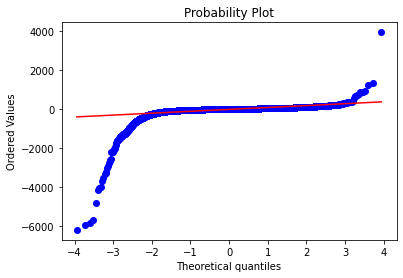

In [35]:
# qq plot for the train residuals
stats.probplot(ridge_data_vals[2]['y_pred'] - ridge_data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

### Lasso Regression with Untransformed Response

In [37]:
reg_params = 10.**np.linspace(-10, 5, 10)
LassoCV_model = model_iterations(5, x, y, LassoCV(alphas=reg_params, fit_intercept=True, cv=5))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5346647.036249995, tolerance: 69390.5835998812
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5334999.969771981, tolerance: 69390.5835998812
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5334739.737746179, tolerance: 69390.5835998812
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase 

Mean Train Score: 0.3318939739054948
Mean Test Score: 0.2864319036665718


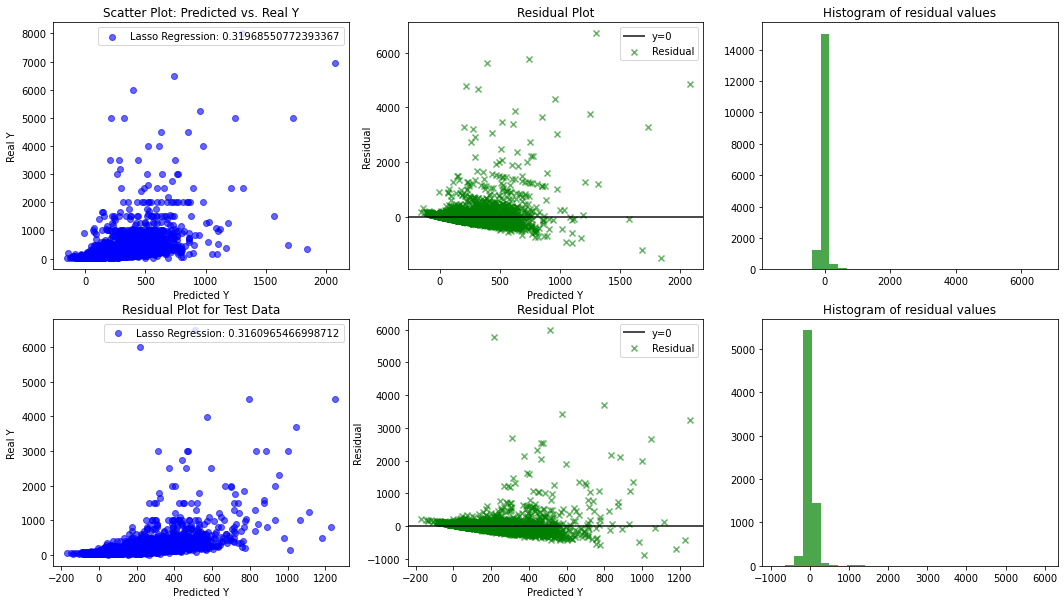

In [38]:
# plot the residuals for a lasso regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

lasso_data_vals = LassoCV_model.data_frame_convert()
plot_residual(axes[0][0], axes[0][1], axes[0][2], lasso_data_vals[2]['y_pred'], lasso_data_vals[2]['y_real'], 'Lasso Regression: {}'.format(lasso_data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], lasso_data_vals[3]['y_pred_test'], lasso_data_vals[3]['y_real_test'], 'Lasso Regression: {}'.format(lasso_data_vals[1]), 'Residual Plot for Test Data')
plt.show()

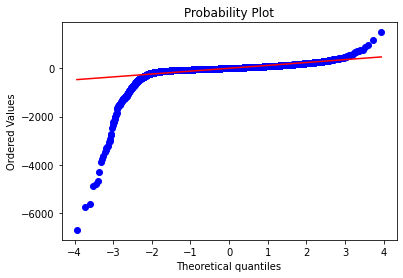

In [39]:
# qq plot for the train residuals
stats.probplot(lasso_data_vals[2]['y_pred'] - lasso_data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

### Lasso Regression with Log-Transformed Response

In [43]:
reg_params = 10.**np.linspace(-10, 5, 10)
LassoCV_model = model_iterations(5, x, y_log, LassoCV(alphas=reg_params, fit_intercept=True, cv=5), True)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0847485908529961, tolerance: 0.573624456377087
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.371782255172548, tolerance: 0.573624456377087
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.371552057124518, tolerance: 0.573624456377087
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to incre

Mean Train Score: 0.3206846313189303
Mean Test Score: 0.3393663426473183


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 237.05647430370323, tolerance: 0.734319325274653
  positive)


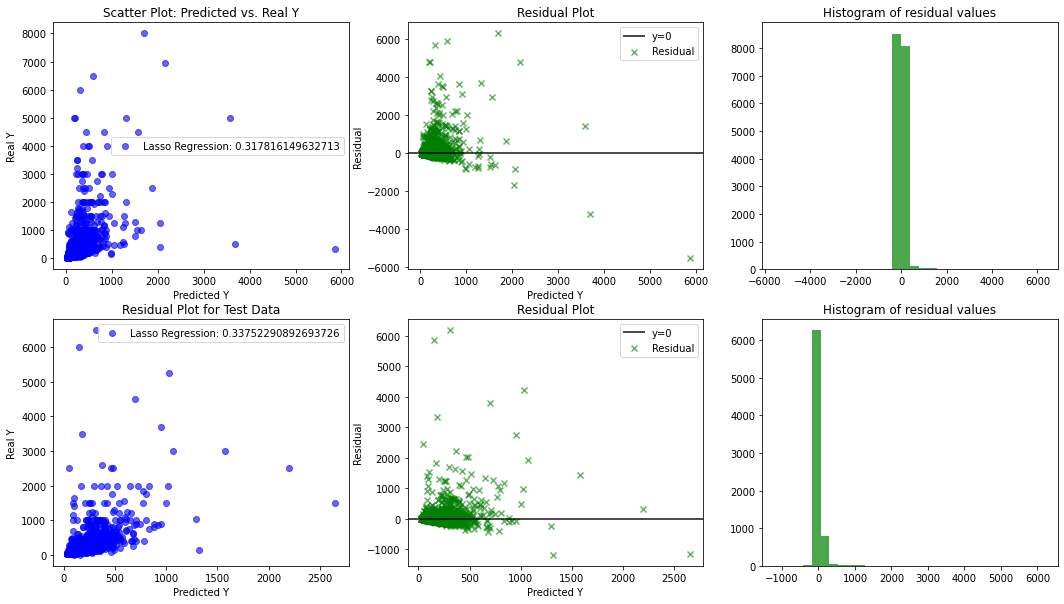

In [44]:
# plot the residuals of a lasso regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

lasso_data_vals = LassoCV_model.data_frame_convert_log()
plot_residual(axes[0][0], axes[0][1], axes[0][2], lasso_data_vals[2]['y_pred'], lasso_data_vals[2]['y_real'], 'Lasso Regression: {}'.format(lasso_data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], lasso_data_vals[3]['y_pred_test'], lasso_data_vals[3]['y_real_test'], 'Lasso Regression: {}'.format(lasso_data_vals[1]), 'Residual Plot for Test Data')
plt.show()

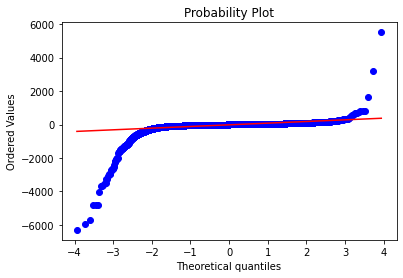

In [45]:
# qq plot for the train residuals
stats.probplot(lasso_data_vals[2]['y_pred'] - lasso_data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

### Results of Ridge and Lasso Regression

  * Visually, we can see that both models performed pretty close on both the training and testing sets. The $R^2$ score for the LR, Ridge and Lasso models also performed pretty close in similarity. With that said, both the Ridge and Lasso performed better in terms of the test score. There isn't a lot of difference between the Transformed and Untransformed response, nor does there seem to be much difference between the train and test scores. 

## Mean Absolute Error

In [61]:
# The plan is to analyze the models previously ran by the MAE. It tends to be less 
# sensative compared to its sister MSE.

In [63]:
def median_absolute_errors(x, y, log_bool=None):
    reg_params = 10.**np.linspace(-10, 5, 10)
    models = [ linear_model.Ridge(), RidgeCV(alphas=reg_params, cv=5), linear_model.Lasso(), LassoCV(alphas=reg_params, cv=5), linear_model.ElasticNet(), linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
    model_labels = np.array(['Ridge', 'RidgeCV', 'Lasso', 'LassoCV', 'ElasticNet', 'BayesRidge', 'OMP'])
    model_errors = np.array([])

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=15)

    for model in models:
        model.fit(X_train, y_train)
        if not log_bool:
            model_err = metrics.median_absolute_error((y_test), model.predict(X_test))
            model_errors = np.append(model_errors, model_err)
        else:
            model_err = metrics.median_absolute_error(np.exp(y_test), np.exp(model.predict(X_test)))
            model_errors = np.append(model_errors, model_err)
    
    model_position = np.arange(model_errors.shape[0])
    models_sorted = np.argsort(model_errors)
    for i, model in enumerate(model_labels):
        print('Model {} Results: {}'.format(model_labels[i], model_errors[i]))

    plt.figure(figsize=(10,8))
    plt.bar(model_position, model_errors[models_sorted], align='center')
    plt.xticks(model_position, model_labels[models_sorted])
    plt.xlabel('Estimator')
    plt.ylabel('Median Absolute Error')
    plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11853882.322800398, tolerance: 63829.65880499003
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11842837.4483729, tolerance: 63829.65880499003
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11842528.150675118, tolerance: 63829.65880499003
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to incre

Model Ridge Results: 43.99297662167493
Model RidgeCV Results: 41.63684741346336
Model Lasso Results: 42.32216327228049
Model LassoCV Results: 43.537411041033366
Model ElasticNet Results: 45.73317930514594
Model BayesRidge Results: 43.04093748940704
Model OMP Results: 44.68825965306053


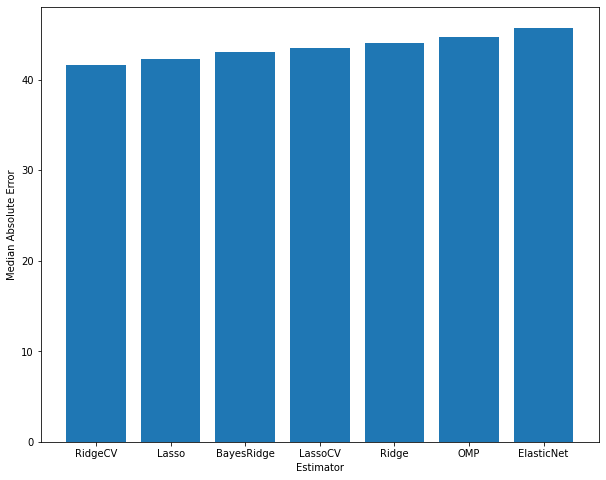

In [64]:
# I will start with the MAE Untransformed Response 

median_absolute_errors(x, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354.42216259616146, tolerance: 0.5372745108339149
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354.33204745281375, tolerance: 0.5372745108339149
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354.3299417460155, tolerance: 0.5372745108339149
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to i

Model Ridge Results: 24.69822281875763
Model RidgeCV Results: 24.69822281875763
Model Lasso Results: 54.35580118841369
Model LassoCV Results: 24.728910883102657
Model ElasticNet Results: 54.35580118841369
Model BayesRidge Results: 24.701906556390306
Model OMP Results: 28.709904663991495


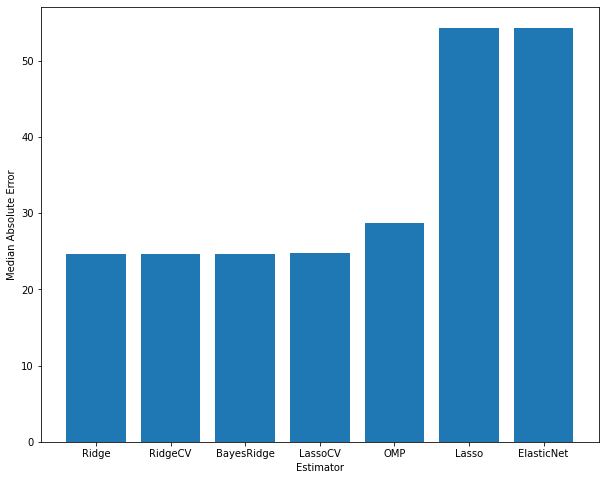

In [65]:
# And now the Median Absolute Error Log-Transformed Response

median_absolute_errors(x, y_log, True)

### So when you analyze the models by their Mean Absolute Error, you can clearly see that a model with a Log-Transformed Response absolutely outperforms the model with an untransformed response. 

### What's most interesting is that the LassoCV outperforms the Lasso model without tuning. 

### The problem with both the Mean and Median Error's, is that the difference in the $R^2$ scores could not be easily distinguished. 

In [69]:
# Next we will take a look at a Random Forest Regressor

def random_forest_model(x_train, y_train, x_test, y_test):
    best_test_score = 0
    best_train_score = 0
    best_depth = 0
    # tune for tree depth from 1 to 20
    for j in range(1, 21):
        rf = RandomForestRegressor(n_estimators=50, max_depth=j, oob_score=True)
        rf.fit(x_train, y_train)
        score_train = rf.score(x_train, y_train)
        score = rf.score(x_test, y_test)
        if score > best_test_score:
            best_test_score = score
            best_train_score = score_train
            best_depth = j
    return best_train_score, best_test_score, best_depth

def random_forest_tuned(best_depth, x, y, description, log_bool=None):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35)
    rf = RandomForestRegressor(n_estimators=50, max_depth=best_depth, oob_score=True)
    rf.fit(x_train, y_train)
    y_pred_test = rf.predict(x_test)
    if not log_bool:
        print('{}'.format(description), metrics.median_absolute_error(y_pred_test, y_test))
    if log_bool:
        print ('{}'.format(description), metrics.median_absolute_error(np.exp(y_pred_test), np.exp(y_test)))

In [71]:
# Random Forest Regressor Untransformed Response

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35)
rf_values = random_forest_model(x_train, y_train, x_test, y_test)

In [72]:
# Print the outputs

print('Train Score with Best Test:', rf_values[0])
print('Best Test Score:', rf_values[1])
print('Best Depth', rf_values[2])

Train Score with Best Test: 0.6006855981131217
Best Test Score: 0.30369492384001473
Best Depth 7


In [73]:
random_forest_tuned(rf_values[2], x, y, 'Median Absolute Error for Untransformed Response:')

Median Absolute Error for Untransformed Response: 36.23872014076332


In [74]:
# Random Forest Regresson with Log-Transformed Response

x_train, x_test, y_train, y_test = train_test_split(x, y_log, test_size=0.35)
rf_values = random_forest_model(x_train, y_train, x_test, y_test)

In [75]:
random_forest_tuned(rf_values[2], x, y, 'Median Absolute Error for Log-Transformed Response:')

Median Absolute Error for Log-Transformed Response: 30.154867833231272


### We can see that with the Random Forest Regressor ouptuts a slightly higher untransformed score than a Ridge or Lasso model, which to me indicates that there might be some overfitting going on. There is a similar test score that comes in slightly higher when you compare it to the Ridge and Lasso Regression models. 

### When you look the Median Absolute Error, it is clear that using a Log-Transofmed Response outperforms that of a Non-Transformed Response. From a computational standpoint, it would take some time to tune for the absolute best params. With that said, it would be possible to decrease the Median Absolute Error using an ensemble method. 